BERT para 64 tokens y weight decay 0,001

##NOTA
Antes de ejecutar los optimizadores para probar distintos parametros, se ha reiniciado el kernel y se han vuelto a ejecutar las primeras celdas, para asegurar de que cada ejecución de BERT no se ve afectada por ejecuciones anteriores

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

df= pd.read_csv('/content/drive/MyDrive/sentiment140_vader4_sinlematizar.csv')


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

In [4]:
!pip install autocorrect

In [5]:
import re
from autocorrect import Speller
from nltk.tokenize import TweetTokenizer

# Inicialización de herramientas
spell = Speller(fast=True)
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)  # strip_handles para quitar menciones

# Función para eliminar URLs, hashtags y ciertos patrones no deseados
def quita_URL_y_patrones(frase):
    resultado = frase
    reemplazos = [
        (r'http\S+', '<url>'),            # Eliminar URLs
        (r'pic.twitter.com/\S+', ''),     # Eliminar imágenes adjuntas en tweets
        (r'#\S+', ''),                    # Eliminar hashtags
        (r'@\w+', ''),                    # Eliminar menciones de usuarios
        ('\xa0', ''),                     # Eliminar espacios no estándar
        ('\[removed\]', ''),              # Eliminar el texto "[removed]"
        ('\[deleted\]', '')               # Eliminar el texto "[deleted]"
    ]

    for patron, reemplazo in reemplazos:
        resultado = re.sub(patron, reemplazo, resultado)

    return resultado

# Función principal que aplica autocorrector y elimina URLs, hashtags, menciones
def preprocesa(dataset_values):
    resultados = []

    for frase in dataset_values:
        # Eliminar URLs, hashtags, y menciones
        frase_sin_urls = quita_URL_y_patrones(frase)
        # Corregir ortografía
        frase_corregida = spell(frase_sin_urls)
        resultados.append(frase_corregida)

    return resultados


In [6]:
df['Tweet'] = preprocesa(df['text'])

In [7]:
labels = df.label.values
text = df.Tweet.values

In [8]:
from transformers import BertTokenizer,BertForSequenceClassification,AdamW

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
input_ids = []
attention_mask = []
for i in text:
    encoded_data = tokenizer.encode_plus(
    i,
    add_special_tokens=True,
    max_length=64,
    pad_to_max_length = True,
    return_attention_mask= True,
    return_tensors='pt')
    input_ids.append(encoded_data['input_ids'])
    attention_mask.append(encoded_data['attention_mask'])
input_ids = torch.cat(input_ids,dim=0)
attention_mask = torch.cat(attention_mask,dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


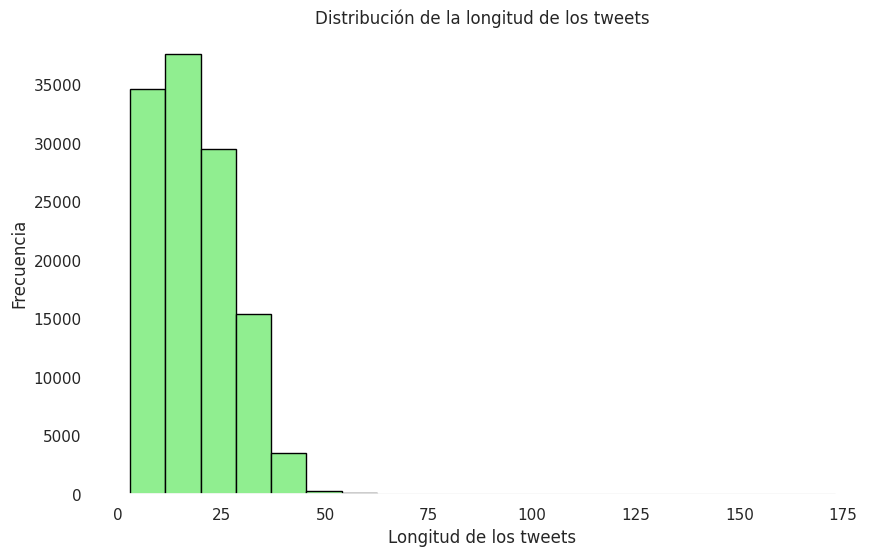

Longitud promedio: 18.24843935790725
Percentil 90: 31.0
Percentil 95: 35.0
Longitud máxima: 173


In [11]:
import matplotlib.pyplot as plt

# Suponiendo que `text` es una lista de tus tweets
lengths = [len(tokenizer.tokenize(t)) for t in text]



# Crear un histograma del número de palabras por tweet
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=20, edgecolor='black', color='lightgreen')
plt.xlabel('Longitud de los tweets')
plt.ylabel('Frecuencia')
plt.title('Distribución de la longitud de los tweets')
# Establecer el fondo de la figura y de los ejes a blanco
plt.gcf().set_facecolor('white')  # Fondo de la figura
plt.gca().set_facecolor('white')  # Fondo del eje
plt.grid(True)
plt.show()

# Calcular la longitud media y percentiles
print(f'Longitud promedio: {sum(lengths)/len(lengths)}')
print(f'Percentil 90: {np.percentile(lengths, 90)}')
print(f'Percentil 95: {np.percentile(lengths, 95)}')
print(f'Longitud máxima: {max(lengths)}')


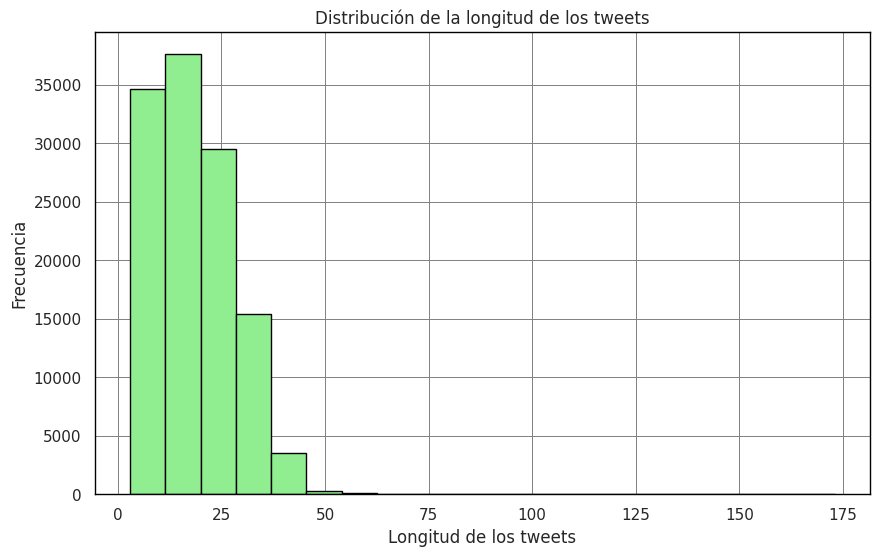

Longitud promedio: 18.24843935790725
Percentil 90: 31.0
Percentil 95: 35.0
Longitud máxima: 173


In [ ]:
# Crear un histograma del número de palabras por tweet
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=20, edgecolor='black', color='lightgreen')
plt.xlabel('Longitud de los tweets')
plt.ylabel('Frecuencia')
plt.title('Distribución de la longitud de los tweets')

# Establecer el fondo de la figura y de los ejes a blanco
plt.gcf().set_facecolor('white')  # Fondo de la figura
plt.gca().set_facecolor('white')  # Fondo del eje

# Establecer color del grid
plt.grid(color='gray', linestyle='-', linewidth=0.7)  # Color y estilo del grid

# Asegurar que los ejes sean visibles
plt.gca().spines['top'].set_color('black')  # Color de la línea superior
plt.gca().spines['right'].set_color('black')  # Color de la línea derecha
plt.gca().spines['left'].set_color('black')  # Color de la línea izquierda
plt.gca().spines['bottom'].set_color('black')  # Color de la línea inferior

# Ajustar el grosor de las líneas de los ejes
plt.gca().spines['top'].set_linewidth(1.0)  # Grosor de la línea superior
plt.gca().spines['right'].set_linewidth(1.0)  # Grosor de la línea derecha
plt.gca().spines['left'].set_linewidth(1.0)  # Grosor de la línea izquierda
plt.gca().spines['bottom'].set_linewidth(1.0)  # Grosor de la línea inferior

plt.show()

# Calcular la longitud media y percentiles
print(f'Longitud promedio: {sum(lengths)/len(lengths)}')
print(f'Percentil 90: {np.percentile(lengths, 90)}')
print(f'Percentil 95: {np.percentile(lengths, 95)}')
print(f'Longitud máxima: {max(lengths)}')

In [12]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [13]:
import torch
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split

# Establecer la semilla para la reproducibilidad
torch.manual_seed(34)

# Crear el dataset completo
dataset = TensorDataset(input_ids, attention_mask, labels)

# Convertir labels a numpy para usar en train_test_split
labels_np = labels.numpy()

# Dividir el dataset en train (80%) y test (20%) con estratificación
train_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=labels_np,
    random_state=34
)

# Crear los datasets de train y test
train_dataset = TensorDataset(
    input_ids[train_indices],
    attention_mask[train_indices],
    labels[train_indices]
)

test_dataset = TensorDataset(
    input_ids[test_indices],
    attention_mask[test_indices],
    labels[test_indices]
)

# Ahora dividir el train_dataset en train (80%) y validation (20%) también con estratificación
train_indices, val_indices = train_test_split(
    train_indices,
    test_size=0.2,
    stratify=labels_np[train_indices],
    random_state=34
)

# Crear los datasets finales
train_dataset = TensorDataset(
    input_ids[train_indices],
    attention_mask[train_indices],
    labels[train_indices]
)

val_dataset = TensorDataset(
    input_ids[val_indices],
    attention_mask[val_indices],
    labels[val_indices]
)

# Imprimir los tamaños de cada conjunto
print('Training Size - ', len(train_dataset))
print('Validation Size - ', len(val_dataset))
print('Test Size - ', len(test_dataset))


Training Size -  77506
Validation Size -  19377
Test Size -  24221


In [14]:
import torch

def count_classes(labels):
    # Convertir a numpy si es necesario
    labels_np = labels.numpy() if isinstance(labels, torch.Tensor) else labels
    # Contar el número de 0s (negativos) y 1s (positivos)
    num_negatives = (labels_np == 0).sum()
    num_positives = (labels_np == 1).sum()
    return num_negatives, num_positives

# Contar en cada conjunto de datos
train_negatives, train_positives = count_classes(labels[train_indices])
val_negatives, val_positives = count_classes(labels[val_indices])
test_negatives, test_positives = count_classes(labels[test_indices])

# Imprimir los resultados
print(f'Train set: {train_negatives} negativos, {train_positives} positivos')
print(f'Validation set: {val_negatives} negativos, {val_positives} positivos')
print(f'Test set: {test_negatives} negativos, {test_positives} positivos')


Train set: 35807 negativos, 41699 positivos
Validation set: 8952 negativos, 10425 positivos
Test set: 11190 negativos, 13031 positivos


In [15]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 32)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 32)
test_dl = DataLoader(test_dataset,sampler = SequentialSampler(test_dataset),
                     batch_size = 32)

In [16]:
model = BertForSequenceClassification.from_pretrained(
'bert-base-uncased',
num_labels = 2,
output_attentions = False,
output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [19]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8, weight_decay=0.001)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [21]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [22]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [23]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0):
        """
        patience (int): Número de épocas sin mejora en la pérdida de validación para detener el entrenamiento.
        min_delta (float): Mínima diferencia de pérdida requerida para considerar una mejora.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        # Si es la primera época, guarda la pérdida como la mejor
        if self.best_loss is None:
            self.best_loss = val_loss
        # Si la pérdida actual es menor que la mejor pérdida - min_delta, es una mejora
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Resetea el contador de paciencia
        else:
            self.counter += 1  # Incrementa el contador de épocas sin mejora
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()



# Inicializar Early Stopping con paciencia de 3 épocas y min_delta de 0.01
early_stopping = EarlyStopping(patience=1, min_delta=0.01)

# Ciclo de entrenamiento
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Guardar las predicciones y etiquetas verdaderas
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        train_preds.extend(preds)  # Agregar predicciones de la batch actual
        train_labels.extend(labels)  # Agregar etiquetas de la batch actual

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(train_dl)
    train_acc = accuracy_score(train_labels, train_preds)  # Calcular la accuracy de entrenamiento
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {train_acc}')

    # ----------- Evaluación en conjunto de validación -----------
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)  # Calcular la accuracy de validación
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')

    # ----------- Early Stopping -----------
    early_stopping(val_loss)  # Monitorea la pérdida de validación
    if early_stopping.early_stop:
        tqdm.write("Early stopping triggered. Training stopped.")
        break

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.31590045955350365
Training accuracy: 0.8619719763631203
Validation loss: 0.27345553026365566
Validation accuracy: 0.8818186509779635


Epoch 2:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.20656407750786285
Training accuracy: 0.9169354630609243
Validation loss: 0.28619892072092384
Validation accuracy: 0.8859988646333282
Early stopping triggered. Training stopped.


Test loss: 0.2981215750397512
Test accuracy: 0.8838611122579579
Test Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     11190
           1       0.89      0.89      0.89     13031

    accuracy                           0.88     24221
   macro avg       0.88      0.88      0.88     24221
weighted avg       0.88      0.88      0.88     24221

Test ROC AUC: 0.9539645955965732
Confusion Matrix:
[[ 9773  1417]
 [ 1396 11635]]


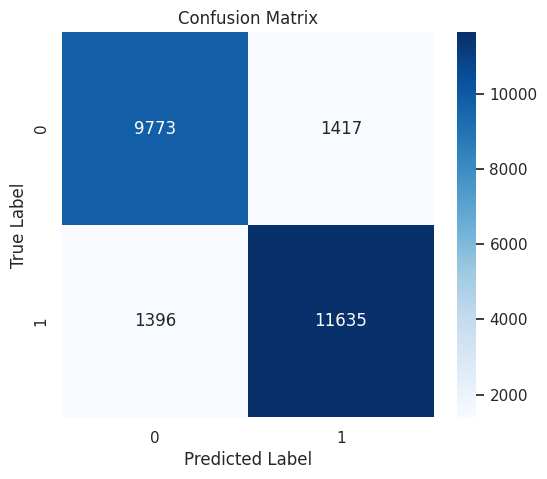

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Función de evaluación del conjunto de test con probabilidades y métricas adicionales
def evaluate_test(dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación

    loss_test_total = 0
    test_preds = []
    test_labels = []
    test_probs = []  # Guardar las probabilidades de la clase positiva (para calcular ROC AUC)

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():  # Desactivar la retropropagación en la evaluación
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_test_total += loss.item()

        # Guardar las predicciones y etiquetas verdaderas
        probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # Probabilidades clase positiva
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        test_preds.extend(preds)  # Agregar predicciones de la batch actual
        test_labels.extend(labels)  # Agregar etiquetas de la batch actual
        test_probs.extend(probs)  # Guardar probabilidades de la clase positiva

    # Calcular la pérdida y precisión media del conjunto de prueba
    loss_test_avg = loss_test_total / len(dataloader)
    test_acc = accuracy_score(test_labels, test_preds)  # Calcular la accuracy de test

    return loss_test_avg, test_acc, test_preds, test_labels, test_probs

# Evaluación en el conjunto de test
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate_test(test_dl)

# Imprimir la pérdida y precisión
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'Test accuracy: {test_acc}')

# ----------- Reporte de Clasificación -----------
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

# ----------- Calcular y Mostrar la ROC AUC -----------
roc_auc = roc_auc_score(test_labels, test_probs)
print(f'Test ROC AUC: {roc_auc}')

# ----------- Matriz de Confusión -----------
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizar la Matriz de Confusión usando Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Test ROC AUC: 0.9539645955965732


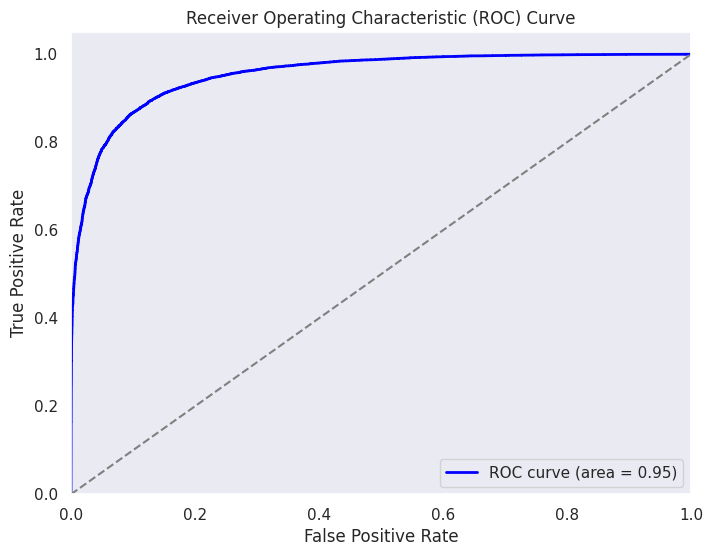

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# ----------- Calcular la Curva ROC y el ROC AUC -----------
# Calcular el ROC AUC (usando las probabilidades de la clase positiva)
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
roc_auc = roc_auc_score(test_labels, test_probs)

# Imprimir el ROC AUC
print(f'Test ROC AUC: {roc_auc}')

# ----------- Graficar la Curva ROC -----------
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')  # Graficar la curva ROC
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
model = BertForSequenceClassification.from_pretrained(
'bert-base-uncased',
num_labels = 2,
output_attentions = False,
output_hidden_states = False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

In [ ]:

optimizer = AdamW(model.parameters(),lr = 5e-6,eps=1e-8, weight_decay=0.001)
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()



# Inicializar Early Stopping con paciencia de 3 épocas y min_delta de 0.01
early_stopping = EarlyStopping(patience=1, min_delta=0.001)

# Ciclo de entrenamiento
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Guardar las predicciones y etiquetas verdaderas
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        train_preds.extend(preds)  # Agregar predicciones de la batch actual
        train_labels.extend(labels)  # Agregar etiquetas de la batch actual

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(train_dl)
    train_acc = accuracy_score(train_labels, train_preds)  # Calcular la accuracy de entrenamiento
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {train_acc}')

    # ----------- Evaluación en conjunto de validación -----------
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)  # Calcular la accuracy de validación
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')

    # ----------- Early Stopping -----------
    early_stopping(val_loss)  # Monitorea la pérdida de validación
    if early_stopping.early_stop:
        tqdm.write("Early stopping triggered. Training stopped.")
        break

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3484154560234593
Training accuracy: 0.8451345702268211
Validation loss: 0.2851263063747694
Validation accuracy: 0.8776900448985911


Epoch 2:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.2662757970961568
Training accuracy: 0.8872732433618042
Validation loss: 0.2789584474250822
Validation accuracy: 0.8806832843061362


Epoch 3:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2347719534306033
Training accuracy: 0.9026010889479524
Validation loss: 0.28927516044046814
Validation accuracy: 0.8818186509779635
Early stopping triggered. Training stopped.


Test loss: 0.30450822401156985
Test accuracy: 0.8792370257214813
Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     11190
           1       0.90      0.87      0.89     13031

    accuracy                           0.88     24221
   macro avg       0.88      0.88      0.88     24221
weighted avg       0.88      0.88      0.88     24221

Test ROC AUC: 0.9511993500890054
Confusion Matrix:
[[ 9993  1197]
 [ 1728 11303]]


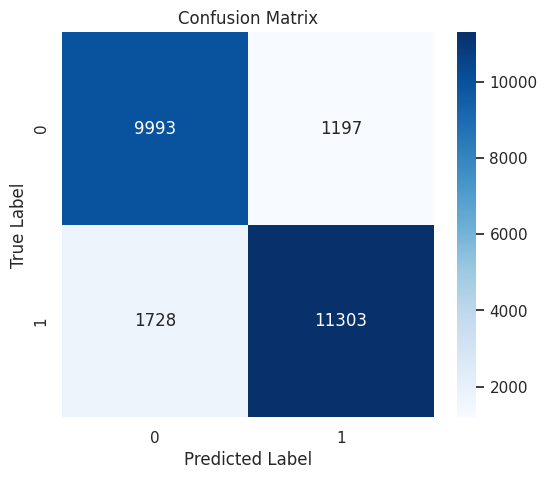

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Función de evaluación del conjunto de test con probabilidades y métricas adicionales
def evaluate_test(dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación

    loss_test_total = 0
    test_preds = []
    test_labels = []
    test_probs = []  # Guardar las probabilidades de la clase positiva (para calcular ROC AUC)

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():  # Desactivar la retropropagación en la evaluación
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_test_total += loss.item()

        # Guardar las predicciones y etiquetas verdaderas
        probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # Probabilidades clase positiva
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        test_preds.extend(preds)  # Agregar predicciones de la batch actual
        test_labels.extend(labels)  # Agregar etiquetas de la batch actual
        test_probs.extend(probs)  # Guardar probabilidades de la clase positiva

    # Calcular la pérdida y precisión media del conjunto de prueba
    loss_test_avg = loss_test_total / len(dataloader)
    test_acc = accuracy_score(test_labels, test_preds)  # Calcular la accuracy de test

    return loss_test_avg, test_acc, test_preds, test_labels, test_probs

# Evaluación en el conjunto de test
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate_test(test_dl)

# Imprimir la pérdida y precisión
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'Test accuracy: {test_acc}')

# ----------- Reporte de Clasificación -----------
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

# ----------- Calcular y Mostrar la ROC AUC -----------
roc_auc = roc_auc_score(test_labels, test_probs)
print(f'Test ROC AUC: {roc_auc}')

# ----------- Matriz de Confusión -----------
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizar la Matriz de Confusión usando Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:

optimizer = AdamW(model.parameters(),lr = 5e-6,eps=1e-8, weight_decay=0.001)
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [ ]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()



# Inicializar Early Stopping con paciencia de 3 épocas y min_delta de 0.01
early_stopping = EarlyStopping(patience=2, min_delta=0.001)

# Ciclo de entrenamiento
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Guardar las predicciones y etiquetas verdaderas
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        train_preds.extend(preds)  # Agregar predicciones de la batch actual
        train_labels.extend(labels)  # Agregar etiquetas de la batch actual

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(train_dl)
    train_acc = accuracy_score(train_labels, train_preds)  # Calcular la accuracy de entrenamiento
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {train_acc}')

    # ----------- Evaluación en conjunto de validación -----------
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)  # Calcular la accuracy de validación
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')

    # ----------- Early Stopping -----------
    early_stopping(val_loss)  # Monitorea la pérdida de validación
    if early_stopping.early_stop:
        tqdm.write("Early stopping triggered. Training stopped.")
        break

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3484154560234593
Training accuracy: 0.8451345702268211
Validation loss: 0.2851263063747694
Validation accuracy: 0.8776900448985911


Epoch 2:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.2662757970961568
Training accuracy: 0.8872732433618042
Validation loss: 0.2789584474250822
Validation accuracy: 0.8806832843061362


Epoch 3:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2347719534306033
Training accuracy: 0.9026010889479524
Validation loss: 0.28927516044046814
Validation accuracy: 0.8818186509779635


Epoch 4:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.21290298929923065
Training accuracy: 0.913619590741362
Validation loss: 0.293253516646182
Validation accuracy: 0.88197347370594
Early stopping triggered. Training stopped.


Test loss: 0.30935464387014017
Test accuracy: 0.8810536311465258
Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     11190
           1       0.89      0.89      0.89     13031

    accuracy                           0.88     24221
   macro avg       0.88      0.88      0.88     24221
weighted avg       0.88      0.88      0.88     24221

Test ROC AUC: 0.95113878783178
Confusion Matrix:
[[ 9788  1402]
 [ 1479 11552]]


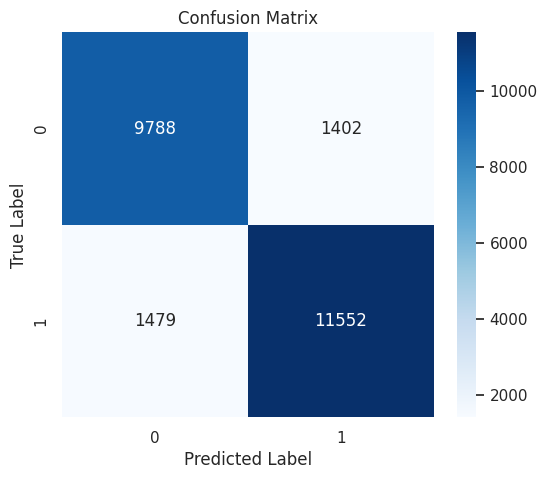

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Función de evaluación del conjunto de test con probabilidades y métricas adicionales
def evaluate_test(dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación

    loss_test_total = 0
    test_preds = []
    test_labels = []
    test_probs = []  # Guardar las probabilidades de la clase positiva (para calcular ROC AUC)

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():  # Desactivar la retropropagación en la evaluación
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_test_total += loss.item()

        # Guardar las predicciones y etiquetas verdaderas
        probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # Probabilidades clase positiva
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        test_preds.extend(preds)  # Agregar predicciones de la batch actual
        test_labels.extend(labels)  # Agregar etiquetas de la batch actual
        test_probs.extend(probs)  # Guardar probabilidades de la clase positiva

    # Calcular la pérdida y precisión media del conjunto de prueba
    loss_test_avg = loss_test_total / len(dataloader)
    test_acc = accuracy_score(test_labels, test_preds)  # Calcular la accuracy de test

    return loss_test_avg, test_acc, test_preds, test_labels, test_probs

# Evaluación en el conjunto de test
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate_test(test_dl)

# Imprimir la pérdida y precisión
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'Test accuracy: {test_acc}')

# ----------- Reporte de Clasificación -----------
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

# ----------- Calcular y Mostrar la ROC AUC -----------
roc_auc = roc_auc_score(test_labels, test_probs)
print(f'Test ROC AUC: {roc_auc}')

# ----------- Matriz de Confusión -----------
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizar la Matriz de Confusión usando Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8, weight_decay=0.001)
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [ ]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()



# Inicializar Early Stopping con paciencia de 3 épocas y min_delta de 0.01
early_stopping = EarlyStopping(patience=2, min_delta=0.001)

# Ciclo de entrenamiento
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Guardar las predicciones y etiquetas verdaderas
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        train_preds.extend(preds)  # Agregar predicciones de la batch actual
        train_labels.extend(labels)  # Agregar etiquetas de la batch actual

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(train_dl)
    train_acc = accuracy_score(train_labels, train_preds)  # Calcular la accuracy de entrenamiento
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {train_acc}')

    # ----------- Evaluación en conjunto de validación -----------
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)  # Calcular la accuracy de validación
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')

    # ----------- Early Stopping -----------
    early_stopping(val_loss)  # Monitorea la pérdida de validación
    if early_stopping.early_stop:
        tqdm.write("Early stopping triggered. Training stopped.")
        break

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.31590045955350365
Training accuracy: 0.8619719763631203
Validation loss: 0.27345553026365566
Validation accuracy: 0.8818186509779635


Epoch 2:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.20656407750786285
Training accuracy: 0.9169354630609243
Validation loss: 0.28619892072092384
Validation accuracy: 0.8859988646333282


Epoch 3:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.12572898909859312
Training accuracy: 0.9545325523185302
Validation loss: 0.3987415255256391
Validation accuracy: 0.8832120555297518
Early stopping triggered. Training stopped.


Test loss: 0.41254409027988365
Test accuracy: 0.8821683662937121
Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     11190
           1       0.89      0.89      0.89     13031

    accuracy                           0.88     24221
   macro avg       0.88      0.88      0.88     24221
weighted avg       0.88      0.88      0.88     24221

Test ROC AUC: 0.9507016745453836
Confusion Matrix:
[[ 9805  1385]
 [ 1469 11562]]


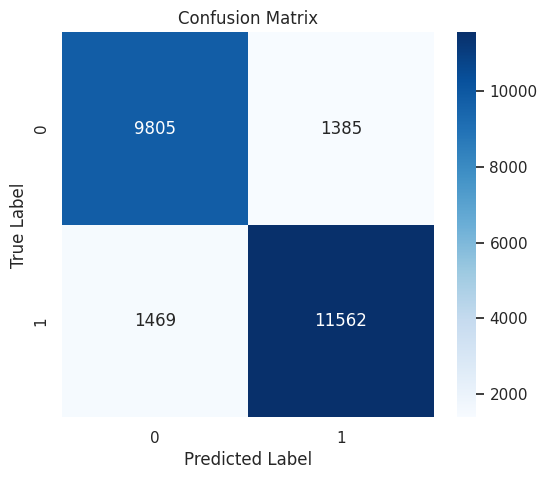

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Función de evaluación del conjunto de test con probabilidades y métricas adicionales
def evaluate_test(dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación

    loss_test_total = 0
    test_preds = []
    test_labels = []
    test_probs = []  # Guardar las probabilidades de la clase positiva (para calcular ROC AUC)

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():  # Desactivar la retropropagación en la evaluación
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_test_total += loss.item()

        # Guardar las predicciones y etiquetas verdaderas
        probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # Probabilidades clase positiva
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        test_preds.extend(preds)  # Agregar predicciones de la batch actual
        test_labels.extend(labels)  # Agregar etiquetas de la batch actual
        test_probs.extend(probs)  # Guardar probabilidades de la clase positiva

    # Calcular la pérdida y precisión media del conjunto de prueba
    loss_test_avg = loss_test_total / len(dataloader)
    test_acc = accuracy_score(test_labels, test_preds)  # Calcular la accuracy de test

    return loss_test_avg, test_acc, test_preds, test_labels, test_probs

# Evaluación en el conjunto de test
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate_test(test_dl)

# Imprimir la pérdida y precisión
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'Test accuracy: {test_acc}')

# ----------- Reporte de Clasificación -----------
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

# ----------- Calcular y Mostrar la ROC AUC -----------
roc_auc = roc_auc_score(test_labels, test_probs)
print(f'Test ROC AUC: {roc_auc}')

# ----------- Matriz de Confusión -----------
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizar la Matriz de Confusión usando Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

AJUSTAR WARMUPS

In [ ]:
total_steps

9692

In [ ]:
warmup_num=total_steps*0.05
warmup_num

484.6

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8, weight_decay=0.001)
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=485,
                                           num_training_steps=total_steps)

In [ ]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()



# Inicializar Early Stopping con paciencia de 3 épocas y min_delta de 0.01
early_stopping = EarlyStopping(patience=1, min_delta=0.001)

# Ciclo de entrenamiento
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Guardar las predicciones y etiquetas verdaderas
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        train_preds.extend(preds)  # Agregar predicciones de la batch actual
        train_labels.extend(labels)  # Agregar etiquetas de la batch actual

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(train_dl)
    train_acc = accuracy_score(train_labels, train_preds)  # Calcular la accuracy de entrenamiento
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {train_acc}')

    # ----------- Evaluación en conjunto de validación -----------
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)  # Calcular la accuracy de validación
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')

    # ----------- Early Stopping -----------
    early_stopping(val_loss)  # Monitorea la pérdida de validación
    if early_stopping.early_stop:
        tqdm.write("Early stopping triggered. Training stopped.")
        break

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3407417065715721
Training accuracy: 0.845302299176838
Validation loss: 0.27681928123086197
Validation accuracy: 0.8804768540021675


Epoch 2:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.21547435908691726
Training accuracy: 0.9132067194797822
Validation loss: 0.28205405036755915
Validation accuracy: 0.8861536873613046
Early stopping triggered. Training stopped.


Test loss: 0.2941557701032417
Test accuracy: 0.8834895338755625
Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     11190
           1       0.89      0.89      0.89     13031

    accuracy                           0.88     24221
   macro avg       0.88      0.88      0.88     24221
weighted avg       0.88      0.88      0.88     24221

Test ROC AUC: 0.9538543854556217
Confusion Matrix:
[[ 9794  1396]
 [ 1426 11605]]


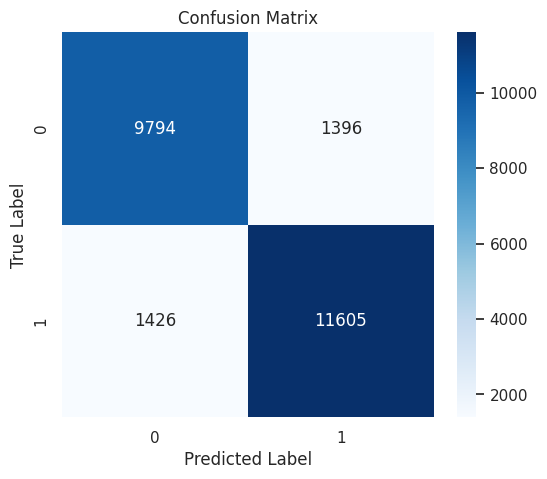

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Función de evaluación del conjunto de test con probabilidades y métricas adicionales
def evaluate_test(dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación

    loss_test_total = 0
    test_preds = []
    test_labels = []
    test_probs = []  # Guardar las probabilidades de la clase positiva (para calcular ROC AUC)

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():  # Desactivar la retropropagación en la evaluación
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_test_total += loss.item()

        # Guardar las predicciones y etiquetas verdaderas
        probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # Probabilidades clase positiva
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        test_preds.extend(preds)  # Agregar predicciones de la batch actual
        test_labels.extend(labels)  # Agregar etiquetas de la batch actual
        test_probs.extend(probs)  # Guardar probabilidades de la clase positiva

    # Calcular la pérdida y precisión media del conjunto de prueba
    loss_test_avg = loss_test_total / len(dataloader)
    test_acc = accuracy_score(test_labels, test_preds)  # Calcular la accuracy de test

    return loss_test_avg, test_acc, test_preds, test_labels, test_probs

# Evaluación en el conjunto de test
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate_test(test_dl)

# Imprimir la pérdida y precisión
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'Test accuracy: {test_acc}')

# ----------- Reporte de Clasificación -----------
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

# ----------- Calcular y Mostrar la ROC AUC -----------
roc_auc = roc_auc_score(test_labels, test_probs)
print(f'Test ROC AUC: {roc_auc}')

# ----------- Matriz de Confusión -----------
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizar la Matriz de Confusión usando Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8, weight_decay=0.001)
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=485,
                                           num_training_steps=total_steps)

In [ ]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()



# Inicializar Early Stopping con paciencia de 3 épocas y min_delta de 0.01
early_stopping = EarlyStopping(patience=2, min_delta=0.001)

# Ciclo de entrenamiento
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Guardar las predicciones y etiquetas verdaderas
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        train_preds.extend(preds)  # Agregar predicciones de la batch actual
        train_labels.extend(labels)  # Agregar etiquetas de la batch actual

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(train_dl)
    train_acc = accuracy_score(train_labels, train_preds)  # Calcular la accuracy de entrenamiento
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {train_acc}')

    # ----------- Evaluación en conjunto de validación -----------
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)  # Calcular la accuracy de validación
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')

    # ----------- Early Stopping -----------
    early_stopping(val_loss)  # Monitorea la pérdida de validación
    if early_stopping.early_stop:
        tqdm.write("Early stopping triggered. Training stopped.")
        break

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3407417065715721
Training accuracy: 0.845302299176838
Validation loss: 0.27681928123086197
Validation accuracy: 0.8804768540021675


Epoch 2:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.21547435908691726
Training accuracy: 0.9132067194797822
Validation loss: 0.28205405036755915
Validation accuracy: 0.8861536873613046


Epoch 3:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.13138321438968395
Training accuracy: 0.9527262405491188
Validation loss: 0.37645214708466634
Validation accuracy: 0.8834700934097125
Early stopping triggered. Training stopped.


Test loss: 0.39459663640235304
Test accuracy: 0.881961933859048
Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     11190
           1       0.90      0.88      0.89     13031

    accuracy                           0.88     24221
   macro avg       0.88      0.88      0.88     24221
weighted avg       0.88      0.88      0.88     24221

Test ROC AUC: 0.9505365496411288
Confusion Matrix:
[[ 9906  1284]
 [ 1575 11456]]


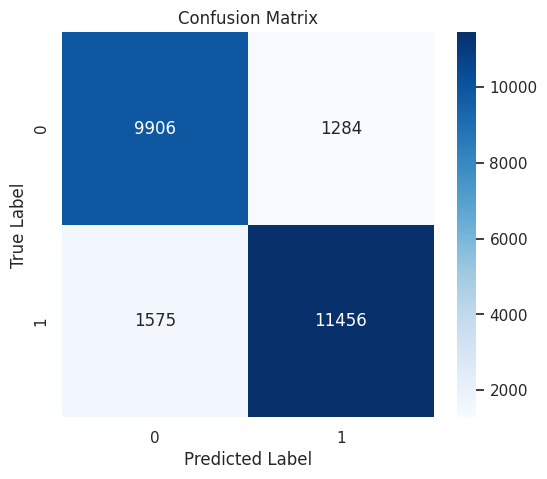

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Función de evaluación del conjunto de test con probabilidades y métricas adicionales
def evaluate_test(dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación

    loss_test_total = 0
    test_preds = []
    test_labels = []
    test_probs = []  # Guardar las probabilidades de la clase positiva (para calcular ROC AUC)

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():  # Desactivar la retropropagación en la evaluación
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_test_total += loss.item()

        # Guardar las predicciones y etiquetas verdaderas
        probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # Probabilidades clase positiva
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        test_preds.extend(preds)  # Agregar predicciones de la batch actual
        test_labels.extend(labels)  # Agregar etiquetas de la batch actual
        test_probs.extend(probs)  # Guardar probabilidades de la clase positiva

    # Calcular la pérdida y precisión media del conjunto de prueba
    loss_test_avg = loss_test_total / len(dataloader)
    test_acc = accuracy_score(test_labels, test_preds)  # Calcular la accuracy de test

    return loss_test_avg, test_acc, test_preds, test_labels, test_probs

# Evaluación en el conjunto de test
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate_test(test_dl)

# Imprimir la pérdida y precisión
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'Test accuracy: {test_acc}')

# ----------- Reporte de Clasificación -----------
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

# ----------- Calcular y Mostrar la ROC AUC -----------
roc_auc = roc_auc_score(test_labels, test_probs)
print(f'Test ROC AUC: {roc_auc}')

# ----------- Matriz de Confusión -----------
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizar la Matriz de Confusión usando Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

WARMUP al 10%

In [ ]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8, weight_decay=0.001)
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=969,
                                           num_training_steps=total_steps)

In [ ]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()



# Inicializar Early Stopping con paciencia de 3 épocas y min_delta de 0.01
early_stopping = EarlyStopping(patience=1, min_delta=0.001)

# Ciclo de entrenamiento
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Guardar las predicciones y etiquetas verdaderas
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        train_preds.extend(preds)  # Agregar predicciones de la batch actual
        train_labels.extend(labels)  # Agregar etiquetas de la batch actual

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(train_dl)
    train_acc = accuracy_score(train_labels, train_preds)  # Calcular la accuracy de entrenamiento
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {train_acc}')

    # ----------- Evaluación en conjunto de validación -----------
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)  # Calcular la accuracy de validación
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')

    # ----------- Early Stopping -----------
    early_stopping(val_loss)  # Monitorea la pérdida de validación
    if early_stopping.early_stop:
        tqdm.write("Early stopping triggered. Training stopped.")
        break

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3572776179439363
Training accuracy: 0.835006322091193
Validation loss: 0.2773347855991263
Validation accuracy: 0.8801672085462146


Epoch 2:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.22560602107350117
Training accuracy: 0.9091683224524553
Validation loss: 0.2834116736082698
Validation accuracy: 0.8835217009857047
Early stopping triggered. Training stopped.


Test loss: 0.29447186013863297
Test accuracy: 0.8825812311630403
Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     11190
           1       0.89      0.89      0.89     13031

    accuracy                           0.88     24221
   macro avg       0.88      0.88      0.88     24221
weighted avg       0.88      0.88      0.88     24221

Test ROC AUC: 0.9538532024650916
Confusion Matrix:
[[ 9768  1422]
 [ 1422 11609]]


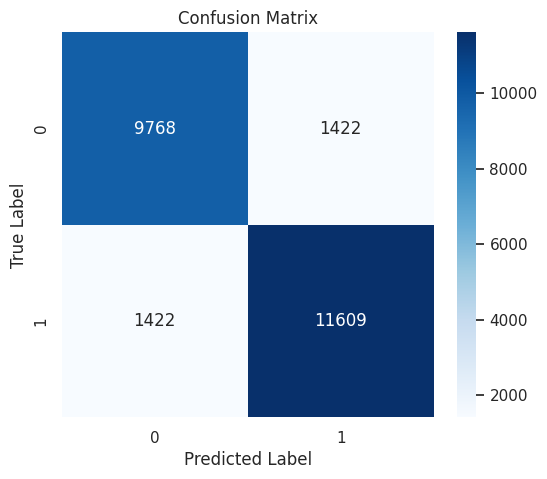

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Función de evaluación del conjunto de test con probabilidades y métricas adicionales
def evaluate_test(dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación

    loss_test_total = 0
    test_preds = []
    test_labels = []
    test_probs = []  # Guardar las probabilidades de la clase positiva (para calcular ROC AUC)

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():  # Desactivar la retropropagación en la evaluación
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_test_total += loss.item()

        # Guardar las predicciones y etiquetas verdaderas
        probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # Probabilidades clase positiva
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        test_preds.extend(preds)  # Agregar predicciones de la batch actual
        test_labels.extend(labels)  # Agregar etiquetas de la batch actual
        test_probs.extend(probs)  # Guardar probabilidades de la clase positiva

    # Calcular la pérdida y precisión media del conjunto de prueba
    loss_test_avg = loss_test_total / len(dataloader)
    test_acc = accuracy_score(test_labels, test_preds)  # Calcular la accuracy de test

    return loss_test_avg, test_acc, test_preds, test_labels, test_probs

# Evaluación en el conjunto de test
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate_test(test_dl)

# Imprimir la pérdida y precisión
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'Test accuracy: {test_acc}')

# ----------- Reporte de Clasificación -----------
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

# ----------- Calcular y Mostrar la ROC AUC -----------
roc_auc = roc_auc_score(test_labels, test_probs)
print(f'Test ROC AUC: {roc_auc}')

# ----------- Matriz de Confusión -----------
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizar la Matriz de Confusión usando Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8, weight_decay=0.001)
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=969,
                                           num_training_steps=total_steps)

In [24]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()



# Inicializar Early Stopping con paciencia de 3 épocas y min_delta de 0.01
early_stopping = EarlyStopping(patience=2, min_delta=0.001)

# Ciclo de entrenamiento
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Guardar las predicciones y etiquetas verdaderas
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        train_preds.extend(preds)  # Agregar predicciones de la batch actual
        train_labels.extend(labels)  # Agregar etiquetas de la batch actual

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(train_dl)
    train_acc = accuracy_score(train_labels, train_preds)  # Calcular la accuracy de entrenamiento
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {train_acc}')

    # ----------- Evaluación en conjunto de validación -----------
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)  # Calcular la accuracy de validación
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')

    # ----------- Early Stopping -----------
    early_stopping(val_loss)  # Monitorea la pérdida de validación
    if early_stopping.early_stop:
        tqdm.write("Early stopping triggered. Training stopped.")
        break

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3572776179439363
Training accuracy: 0.835006322091193
Validation loss: 0.2773347855991263
Validation accuracy: 0.8801672085462146


Epoch 2:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.22560602107350117
Training accuracy: 0.9091683224524553
Validation loss: 0.2834116736082698
Validation accuracy: 0.8835217009857047


Epoch 3:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.13751355409345448
Training accuracy: 0.9491652259179935
Validation loss: 0.36506242893033786
Validation accuracy: 0.8848118903855086
Early stopping triggered. Training stopped.


Test loss: 0.38354786462181273
Test accuracy: 0.8804343338425333
Test Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     11190
           1       0.90      0.88      0.89     13031

    accuracy                           0.88     24221
   macro avg       0.88      0.88      0.88     24221
weighted avg       0.88      0.88      0.88     24221

Test ROC AUC: 0.9507428048972927
Confusion Matrix:
[[ 9915  1275]
 [ 1621 11410]]


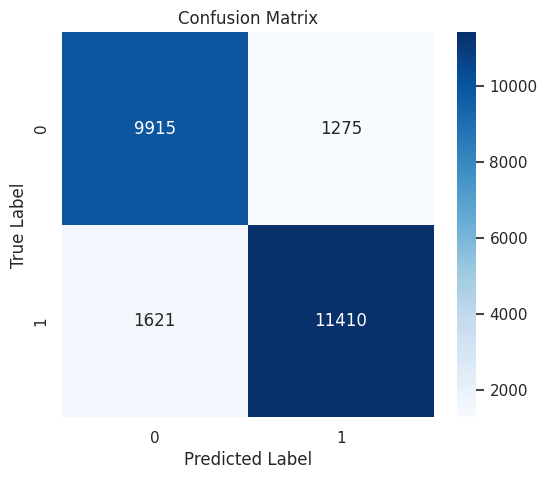

In [25]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Función de evaluación del conjunto de test con probabilidades y métricas adicionales
def evaluate_test(dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación

    loss_test_total = 0
    test_preds = []
    test_labels = []
    test_probs = []  # Guardar las probabilidades de la clase positiva (para calcular ROC AUC)

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():  # Desactivar la retropropagación en la evaluación
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_test_total += loss.item()

        # Guardar las predicciones y etiquetas verdaderas
        probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # Probabilidades clase positiva
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        test_preds.extend(preds)  # Agregar predicciones de la batch actual
        test_labels.extend(labels)  # Agregar etiquetas de la batch actual
        test_probs.extend(probs)  # Guardar probabilidades de la clase positiva

    # Calcular la pérdida y precisión media del conjunto de prueba
    loss_test_avg = loss_test_total / len(dataloader)
    test_acc = accuracy_score(test_labels, test_preds)  # Calcular la accuracy de test

    return loss_test_avg, test_acc, test_preds, test_labels, test_probs

# Evaluación en el conjunto de test
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate_test(test_dl)

# Imprimir la pérdida y precisión
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'Test accuracy: {test_acc}')

# ----------- Reporte de Clasificación -----------
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

# ----------- Calcular y Mostrar la ROC AUC -----------
roc_auc = roc_auc_score(test_labels, test_probs)
print(f'Test ROC AUC: {roc_auc}')

# ----------- Matriz de Confusión -----------
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizar la Matriz de Confusión usando Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##AJUSTAR DROPOUT

In [24]:
from transformers import BertForSequenceClassification, BertConfig

class CustomBertForSequenceClassification(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        # ajustar la tasa de dropout
        self.dropout = nn.Dropout(p=0.3)

# Configura el modelo con dropout
config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

model = CustomBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)


Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8, weight_decay=0.001)
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

cuda


In [26]:
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache()



# Inicializar Early Stopping con paciencia de 3 épocas y min_delta de 0.01
early_stopping = EarlyStopping(patience=1, min_delta=0.001)

# Ciclo de entrenamiento
for epoch in tqdm(range(1, epochs + 1)):

    model.train()

    loss_train_total = 0
    train_preds = []
    train_labels = []

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

        # Guardar las predicciones y etiquetas verdaderas
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        train_preds.extend(preds)  # Agregar predicciones de la batch actual
        train_labels.extend(labels)  # Agregar etiquetas de la batch actual

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total / len(train_dl)
    train_acc = accuracy_score(train_labels, train_preds)  # Calcular la accuracy de entrenamiento
    tqdm.write(f'Training loss: {loss_train_avg}')
    tqdm.write(f'Training accuracy: {train_acc}')

    # ----------- Evaluación en conjunto de validación -----------
    val_loss, predictions, true_vals = evaluate(val_dl)
    val_acc = accuracy(predictions, true_vals)  # Calcular la accuracy de validación
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Validation accuracy: {val_acc}')

    # ----------- Early Stopping -----------
    early_stopping(val_loss)  # Monitorea la pérdida de validación
    if early_stopping.early_stop:
        tqdm.write("Early stopping triggered. Training stopped.")
        break

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3539875986725645
Training accuracy: 0.8411348798802674
Validation loss: 0.29789745062589645
Validation accuracy: 0.8759353873148579


Epoch 2:   0%|          | 0/2423 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.2871374117300449
Training accuracy: 0.8761902304337729
Validation loss: 0.3011050755834275
Validation accuracy: 0.8809413221860969
Early stopping triggered. Training stopped.


Test loss: 0.31536375297678826
Test accuracy: 0.876924982453243
Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87     11190
           1       0.91      0.86      0.88     13031

    accuracy                           0.88     24221
   macro avg       0.88      0.88      0.88     24221
weighted avg       0.88      0.88      0.88     24221

Test ROC AUC: 0.9509946481508419
Confusion Matrix:
[[10034  1156]
 [ 1825 11206]]


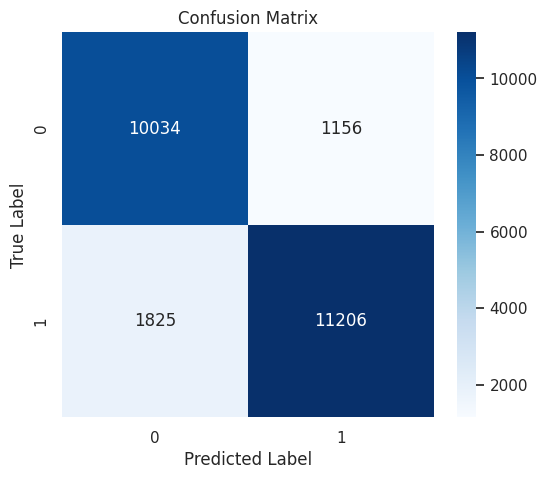

In [27]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Función de evaluación del conjunto de test con probabilidades y métricas adicionales
def evaluate_test(dataloader):
    model.eval()  # Establecer el modelo en modo de evaluación

    loss_test_total = 0
    test_preds = []
    test_labels = []
    test_probs = []  # Guardar las probabilidades de la clase positiva (para calcular ROC AUC)

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}

        with torch.no_grad():  # Desactivar la retropropagación en la evaluación
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]  # Salida de las predicciones

        loss_test_total += loss.item()

        # Guardar las predicciones y etiquetas verdaderas
        probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()  # Probabilidades clase positiva
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()  # Predicciones
        labels = batch[2].detach().cpu().numpy()  # Etiquetas verdaderas

        test_preds.extend(preds)  # Agregar predicciones de la batch actual
        test_labels.extend(labels)  # Agregar etiquetas de la batch actual
        test_probs.extend(probs)  # Guardar probabilidades de la clase positiva

    # Calcular la pérdida y precisión media del conjunto de prueba
    loss_test_avg = loss_test_total / len(dataloader)
    test_acc = accuracy_score(test_labels, test_preds)  # Calcular la accuracy de test

    return loss_test_avg, test_acc, test_preds, test_labels, test_probs

# Evaluación en el conjunto de test
test_loss, test_acc, test_preds, test_labels, test_probs = evaluate_test(test_dl)

# Imprimir la pérdida y precisión
tqdm.write(f'Test loss: {test_loss}')
tqdm.write(f'Test accuracy: {test_acc}')

# ----------- Reporte de Clasificación -----------
print("Test Classification Report:")
print(classification_report(test_labels, test_preds))

# ----------- Calcular y Mostrar la ROC AUC -----------
roc_auc = roc_auc_score(test_labels, test_probs)
print(f'Test ROC AUC: {roc_auc}')

# ----------- Matriz de Confusión -----------
conf_matrix = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(conf_matrix)

# Visualizar la Matriz de Confusión usando Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()